# Parkinsons Disease detection

In [2]:
# Built-in packages
import json
import warnings
import re
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import iplot

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier


sns.set(context= "notebook", color_codes=True)
plt.style.use('bmh')

pyo.init_notebook_mode()

%matplotlib inline
pd.set_option('display.max_columns', None)

**name**$~~~~~~~~~~~~~~~~~~~~~~~~~$- ASCII subject name and recording number
____
**MDVP:Fo(Hz)**$~~~~~~~~~~~~~$- Average vocal fundamental frequency
____
**MDVP:Fhi(Hz)**$~~~~~~~~~~~~$- Maximum vocal fundamental frequency
____
**MDVP:Flo(Hz)**$~~~~~~~~~~~~$- Minimum vocal fundamental frequency
____
**MDVP:Jitter(%), <br>
MDVP:Jitter(Abs), <br>
MDVP:RAP, <br>
MDVP:PPQ, <br>
Jitter:DDP**$~~~~~~~~~~~~~~~~~~$- Several measures of variation in fundamental frequency
____
**MDVP:Shimmer, <br>
MDVP:Shimmer(dB), <br>
Shimmer:APQ3, <br>
Shimmer:APQ5, <br>
MDVP:APQ, <br>
Shimmer:DDA**$~~~~~~~~~~~~~$- Several measures of variation in amplitude
____
**NHR,HNR**$~~~~~~~~~~~~~~~~~~~$- Two measures of ratio of noise to tonal components in the voice
____
**status**$~~~~~~~~~~~~~~~~~~~~~~~~$- Health status of the subject (one) - Parkinson's, (zero) - healthy
____
**RPDE,D2**$~~~~~~~~~~~~~~~~~~~~$- Two nonlinear dynamical complexity measures
____
**DFA**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Signal fractal scaling exponent
____
**spread1, <br>
spread2, <br>
PPE**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Three nonlinear measures of fundamental frequency variation
____

In [13]:
# Read the CSV file and display first 10 rows
df = pd.read_csv("/kaggle/input/parkinsons-data-set/parkinsons.data")
df.columns = [i.replace(" ", "_").replace("(%)", "_perc").replace("(dB)", "_db").replace(":", "_").lower() for i in df.columns]
df.columns = [re.sub(r"\((.+)\)", "", i) for i in df.columns]

df

name  mdvp_fo  mdvp_fhi  mdvp_flo  mdvp_jitter_perc  \
0    phon_R01_S01_1  119.992   157.302    74.997           0.00784   
1    phon_R01_S01_2  122.400   148.650   113.819           0.00968   
2    phon_R01_S01_3  116.682   131.111   111.555           0.01050   
3    phon_R01_S01_4  116.676   137.871   111.366           0.00997   
4    phon_R01_S01_5  116.014   141.781   110.655           0.01284   
..              ...      ...       ...       ...               ...   
190  phon_R01_S50_2  174.188   230.978    94.261           0.00459   
191  phon_R01_S50_3  209.516   253.017    89.488           0.00564   
192  phon_R01_S50_4  174.688   240.005    74.287           0.01360   
193  phon_R01_S50_5  198.764   396.961    74.904           0.00740   
194  phon_R01_S50_6  214.289   260.277    77.973           0.00567   

     mdvp_jitter  mdvp_rap  mdvp_ppq  jitter_ddp  mdvp_shimmer  \
0        0.00007   0.00370   0.00554     0.01109       0.04374   
1        0.00008   0.00465   0.00696     0.01394       0.06134   
2        0.00009   0.00544   0.00781     0.01633       0.05233   
3        0.00009   0.00502   0.00698     0.01505       0.05492   
4        0.00011   0.00655   0.00908     0.01966       0.06425   
..           ...       ...       ...         ...           ...   
190      0.00003   0.00263   0.00259     0.00790       0.04087   
191      0.00003   0.00331   0.00292     0.00994       0.02751   
192      0.00008   0.00624   0.00564     0.01873       0.02308   
193      0.00004   0.00370   0.00390     0.01109       0.02296   
194      0.00003   0.00295   0.00317     0.00885       0.01884   

     mdvp_shimmer_db  shimmer_apq3  shimmer_apq5  mdvp_apq  shimmer_dda  \
0              0.426       0.02182       0.03130   0.02971      0.06545   
1              0.626       0.03134       0.04518   0.04368      0.09403   
2              0.482       0.02757       0.03858   0.03590      0.08270   
3              0.517       0.02924       0.04005   0.03772      0.08771   
4              0.584       0.03490       0.04825   0.04465      0.10470   
..               ...           ...           ...       ...          ...   
190            0.405       0.02336       0.02498   0.02745      0.07008   
191            0.263       0.01604       0.01657   0.01879      0.04812   
192            0.256       0.01268       0.01365   0.01667      0.03804   
193            0.241       0.01265       0.01321   0.01588      0.03794   
194            0.190       0.01026       0.01161   0.01373      0.03078   

         nhr     hnr  status      rpde       dfa   spread1   spread2  \
0    0.02211  21.033       1  0.414783  0.815285 -4.813031  0.266482   
1    0.01929  19.085       1  0.458359  0.819521 -4.075192  0.335590   
2    0.01309  20.651       1  0.429895  0.825288 -4.443179  0.311173   
3    0.01353  20.644       1  0.434969  0.819235 -4.117501  0.334147   
4    0.01767  19.649       1  0.417356  0.823484 -3.747787  0.234513   
..       ...     ...     ...       ...       ...       ...       ...   
190  0.02764  19.517       0  0.448439  0.657899 -6.538586  0.121952   
191  0.01810  19.147       0  0.431674  0.683244 -6.195325  0.129303   
192  0.10715  17.883       0  0.407567  0.655683 -6.787197  0.158453   
193  0.07223  19.020       0  0.451221  0.643956 -6.744577  0.207454   
194  0.04398  21.209       0  0.462803  0.664357 -5.724056  0.190667   

           d2       ppe  
0    2.301442  0.284654  
1    2.486855  0.368674  
2    2.342259  0.332634  
3    2.405554  0.368975  
4    2.332180  0.410335  
..        ...       ...  
190  2.657476  0.133050  
191  2.784312  0.168895  
192  2.679772  0.131728  
193  2.138608  0.123306  
194  2.555477  0.148569  

[195 rows x 24 columns]

In [14]:
print(f"The shape of the DatFrame is: {df.shape}, which means there are {df.shape[0]} rows and {df.shape[1]} columns.")

The shape of the DatFrame is: (195, 24), which means there are 195 rows and 24 columns.


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   mdvp_fo           195 non-null    float64
 2   mdvp_fhi          195 non-null    float64
 3   mdvp_flo          195 non-null    float64
 4   mdvp_jitter_perc  195 non-null    float64
 5   mdvp_jitter       195 non-null    float64
 6   mdvp_rap          195 non-null    float64
 7   mdvp_ppq          195 non-null    float64
 8   jitter_ddp        195 non-null    float64
 9   mdvp_shimmer      195 non-null    float64
 10  mdvp_shimmer_db   195 non-null    float64
 11  shimmer_apq3      195 non-null    float64
 12  shimmer_apq5      195 non-null    float64
 13  mdvp_apq          195 non-null    float64
 14  shimmer_dda       195 non-null    float64
 15  nhr               195 non-null    float64
 16  hnr               195 non-null    float64
 1

In [16]:
# Check if any of the columns have null values
print(df.isnull().sum())

name                0
mdvp_fo             0
mdvp_fhi            0
mdvp_flo            0
mdvp_jitter_perc    0
mdvp_jitter         0
mdvp_rap            0
mdvp_ppq            0
jitter_ddp          0
mdvp_shimmer        0
mdvp_shimmer_db     0
shimmer_apq3        0
shimmer_apq5        0
mdvp_apq            0
shimmer_dda         0
nhr                 0
hnr                 0
status              0
rpde                0
dfa                 0
spread1             0
spread2             0
d2                  0
ppe                 0
dtype: int64


In [17]:
df_summary = df.describe()
df_summary

mdvp_fo    mdvp_fhi    mdvp_flo  mdvp_jitter_perc  mdvp_jitter  \
count  195.000000  195.000000  195.000000        195.000000   195.000000   
mean   154.228641  197.104918  116.324631          0.006220     0.000044   
std     41.390065   91.491548   43.521413          0.004848     0.000035   
min     88.333000  102.145000   65.476000          0.001680     0.000007   
25%    117.572000  134.862500   84.291000          0.003460     0.000020   
50%    148.790000  175.829000  104.315000          0.004940     0.000030   
75%    182.769000  224.205500  140.018500          0.007365     0.000060   
max    260.105000  592.030000  239.170000          0.033160     0.000260   

         mdvp_rap    mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer_db  \
count  195.000000  195.000000  195.000000    195.000000       195.000000   
mean     0.003306    0.003446    0.009920      0.029709         0.282251   
std      0.002968    0.002759    0.008903      0.018857         0.194877   
min      0.000680    0.000920    0.002040      0.009540         0.085000   
25%      0.001660    0.001860    0.004985      0.016505         0.148500   
50%      0.002500    0.002690    0.007490      0.022970         0.221000   
75%      0.003835    0.003955    0.011505      0.037885         0.350000   
max      0.021440    0.019580    0.064330      0.119080         1.302000   

       shimmer_apq3  shimmer_apq5    mdvp_apq  shimmer_dda         nhr  \
count    195.000000    195.000000  195.000000   195.000000  195.000000   
mean       0.015664      0.017878    0.024081     0.046993    0.024847   
std        0.010153      0.012024    0.016947     0.030459    0.040418   
min        0.004550      0.005700    0.007190     0.013640    0.000650   
25%        0.008245      0.009580    0.013080     0.024735    0.005925   
50%        0.012790      0.013470    0.018260     0.038360    0.011660   
75%        0.020265      0.022380    0.029400     0.060795    0.025640   
max        0.056470      0.079400    0.137780     0.169420    0.314820   

              hnr      status        rpde         dfa     spread1     spread2  \
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000   
mean    21.885974    0.753846    0.498536    0.718099   -5.684397    0.226510   
std      4.425764    0.431878    0.103942    0.055336    1.090208    0.083406   
min      8.441000    0.000000    0.256570    0.574282   -7.964984    0.006274   
25%     19.198000    1.000000    0.421306    0.674758   -6.450096    0.174351   
50%     22.085000    1.000000    0.495954    0.722254   -5.720868    0.218885   
75%     25.075500    1.000000    0.587562    0.761881   -5.046192    0.279234   
max     33.047000    1.000000    0.685151    0.825288   -2.434031    0.450493   

               d2         ppe  
count  195.000000  195.000000  
mean     2.381826    0.206552  
std      0.382799    0.090119  
min      1.423287    0.044539  
25%      2.099125    0.137451  
50%      2.361532    0.194052  
75%      2.636456    0.252980  
max      3.671155    0.527367

In [19]:
df.isna().sum()

name                0
mdvp_fo             0
mdvp_fhi            0
mdvp_flo            0
mdvp_jitter_perc    0
mdvp_jitter         0
mdvp_rap            0
mdvp_ppq            0
jitter_ddp          0
mdvp_shimmer        0
mdvp_shimmer_db     0
shimmer_apq3        0
shimmer_apq5        0
mdvp_apq            0
shimmer_dda         0
nhr                 0
hnr                 0
status              0
rpde                0
dfa                 0
spread1             0
spread2             0
d2                  0
ppe                 0
dtype: int64

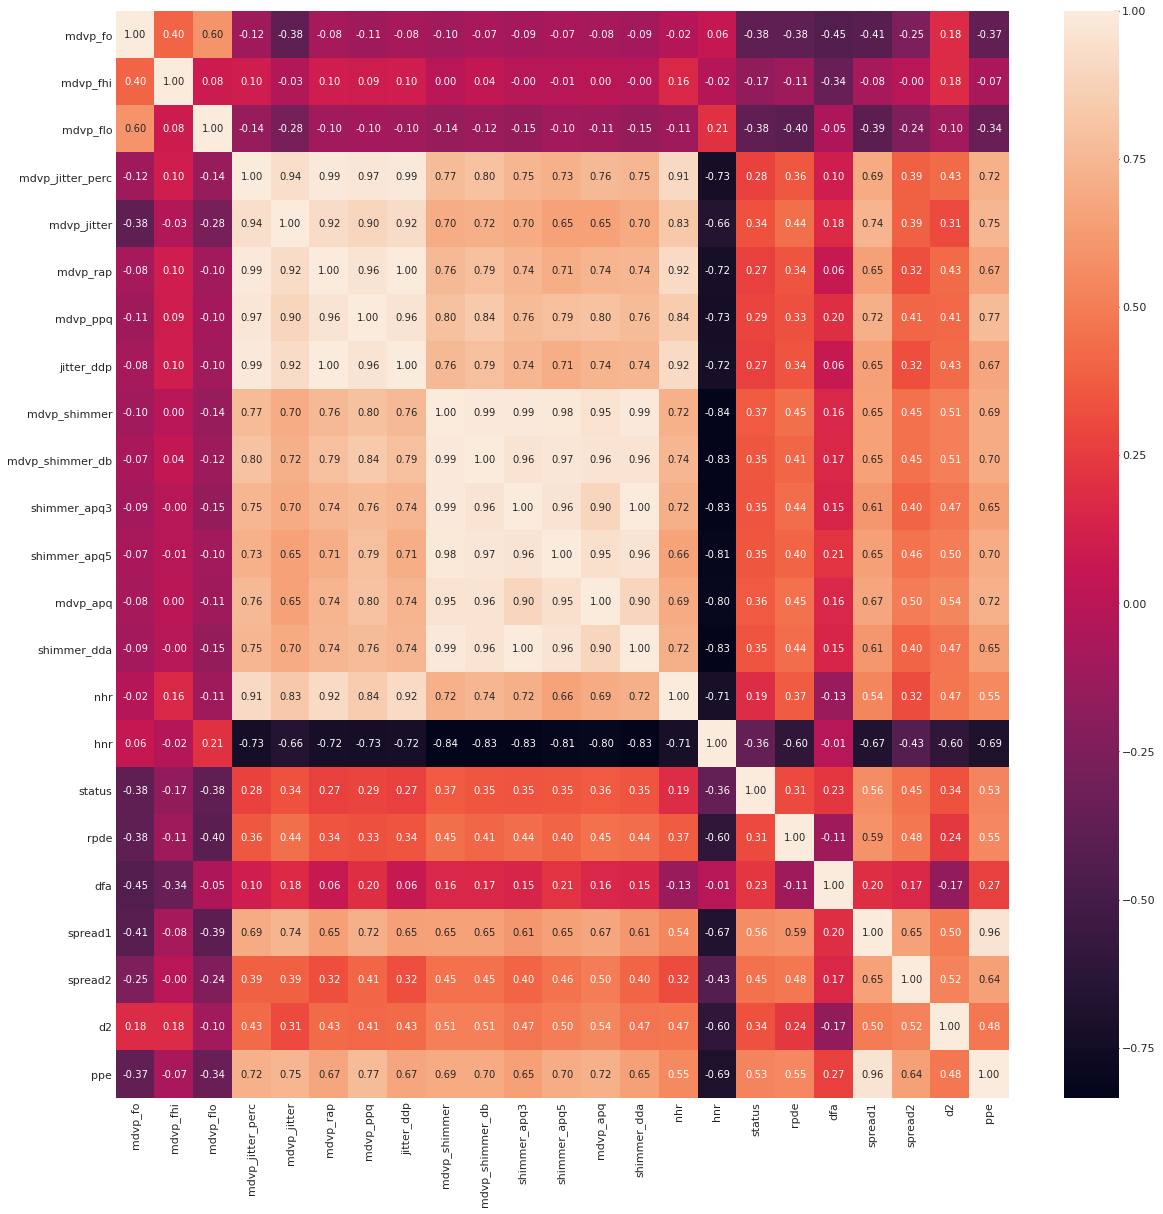

In [22]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), fmt='.2f', annot=True);

## Univariate and Bivariate analysis

In [8]:
# A function that returns value counts for a column split by status
def groupby_get_cc_count(tdf, col):
    tdf = tdf.groupby([col, "status"])["status"].count().reset_index(level = 0)
    tdf.columns = [col, "count"]
    tdf = tdf.reset_index()
    return tdf

In [9]:
df[["mdvp_fo", "mdvp_jitter", "status"]]

mdvp_fo  mdvp_jitter  status
0    119.992      0.00007       1
1    122.400      0.00008       1
2    116.682      0.00009       1
3    116.676      0.00009       1
4    116.014      0.00011       1
..       ...          ...     ...
190  174.188      0.00003       0
191  209.516      0.00003       0
192  174.688      0.00008       0
193  198.764      0.00004       0
194  214.289      0.00003       0

[195 rows x 3 columns]

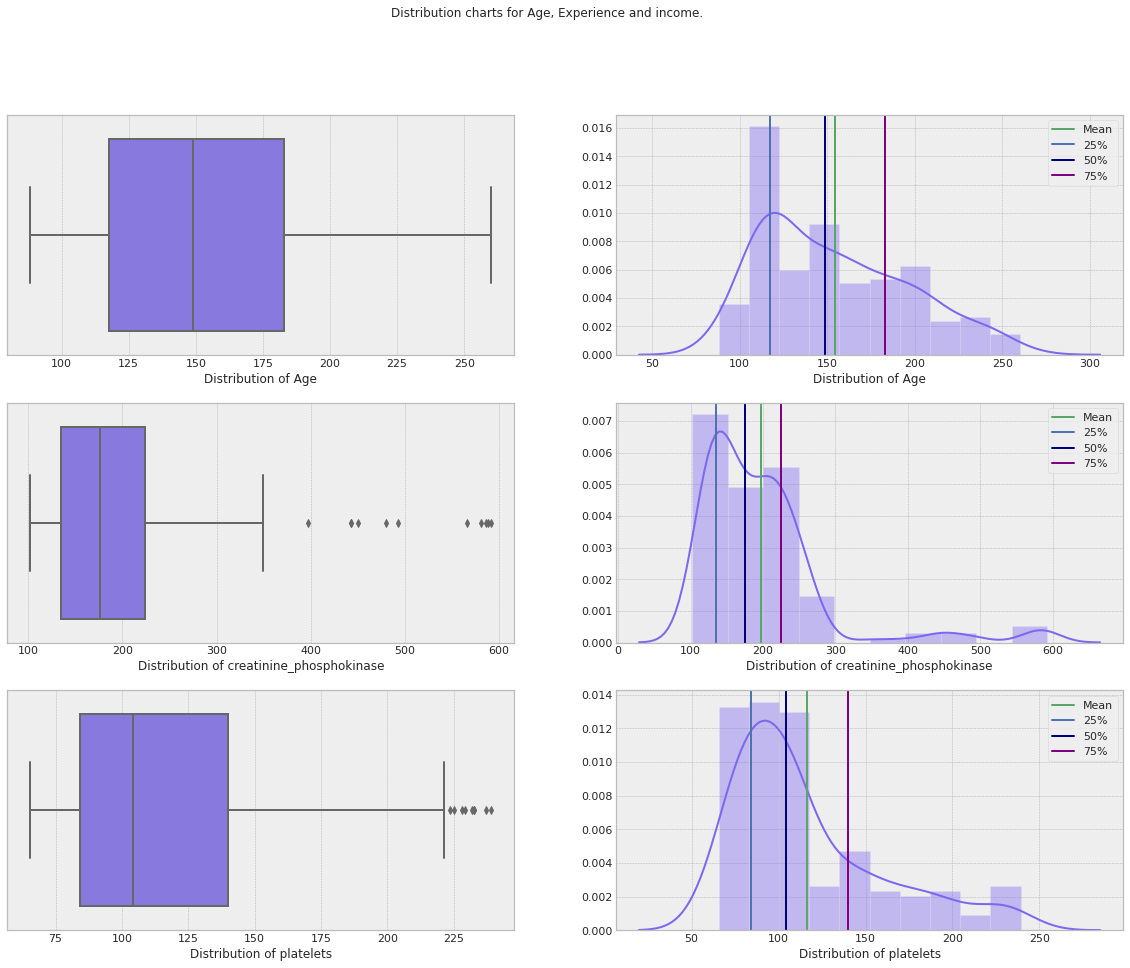

In [10]:
def draw_axvlines(plt, col):
    mean = df_summary.loc["mean", col]
    q1 = df_summary.loc["25%", col]
    q2 = df_summary.loc["50%", col]
    q3 = df_summary.loc["75%", col]
    plt.axvline(mean, color = "g");              # Plotting a line to mark the mean 
    plt.axvline(q1, color = "b");                # Plotting a line to mark Q1 
    plt.axvline(q2, color = "navy");             # Plotting a line to mark Q2 
    plt.axvline(q3, color = "purple");           # Plotting a line to mark Q3
    plt.legend({"Mean": mean, "25%" : q1, "50%" : q2, "75%" : q3});

fig, axes = plt.subplots(3, 2, figsize = (20,15));
fig.suptitle('Distribution charts for Age, Experience and income.');


# Create boxplot to show distribution of Age
sns.boxplot(df["mdvp_fo"], ax = axes[0][0], color = "mediumslateblue");
axes[0][0].set(xlabel = 'Distribution of Age');

pp = sns.distplot(df["mdvp_fo"], ax = axes[0][1], bins = 10, color = "mediumslateblue");
axes[0][1].set(xlabel = 'Distribution of Age');
draw_axvlines(pp, "mdvp_fo");


# Create boxplot to show distribution of creatinine_phosphokinase
sns.boxplot(df["mdvp_fhi"], ax = axes[1][0], color = "mediumslateblue");
axes[1][0].set(xlabel = 'Distribution of creatinine_phosphokinase');

pp = sns.distplot(df["mdvp_fhi"], ax = axes[1][1], bins = 10, color = "mediumslateblue");
axes[1][1].set(xlabel = 'Distribution of creatinine_phosphokinase');
draw_axvlines(pp, "mdvp_fhi")


# Create boxplot to show distribution of platelets
sns.boxplot(df["mdvp_flo"], ax = axes[2][0], color = "mediumslateblue");
axes[2][0].set(xlabel = 'Distribution of platelets');

pp = sns.distplot(df["mdvp_flo"], ax = axes[2][1], color = "mediumslateblue");
axes[2][1].set(xlabel = 'Distribution of platelets');
draw_axvlines(pp, "mdvp_flo")

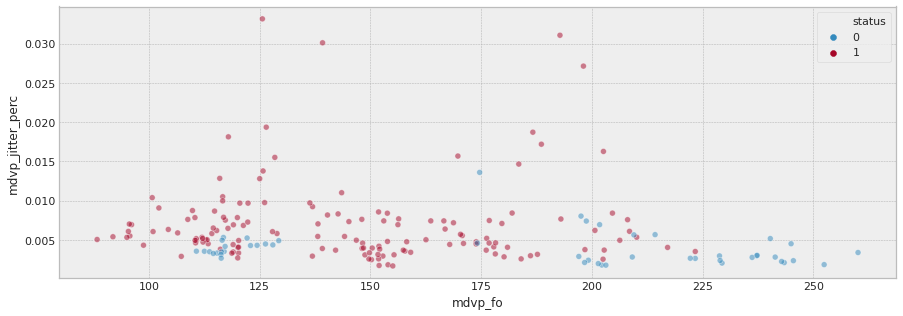

In [23]:
plt.figure(figsize = (15, 5))
sns.scatterplot(x = "mdvp_fo", y = "mdvp_jitter_perc", data = df[["mdvp_fo", "mdvp_jitter_perc", "status"]], hue = "status", alpha = 0.5);

From the above plot, we can see that the people without Parkinsons have their fundamental frequencies that is either high or very low and the percentage of jitter is usually lower that 0.005%.

In [24]:
df_train = df.copy().drop(columns=["name"])
col_names = df_train.columns.tolist()
target_col = ["status"]
col_names.remove(target_col[0])
df_train = df_train[col_names + target_col]

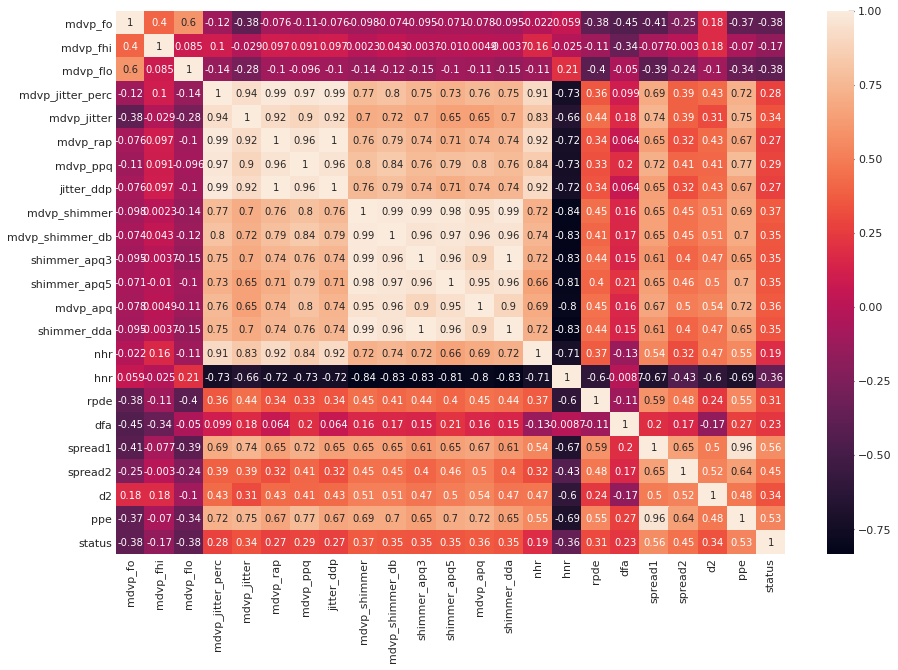

In [25]:
plt.figure(figsize=(15,10))
corr = df_train.corr()
sns.heatmap(corr, annot=True, fmt='.2g');

## Standardization (Scaling)

In [26]:
len(df_train[col_names].columns)

22

In [27]:
std = StandardScaler()

scaled = std.fit_transform(df_train[col_names])     # Standardize the columns to get them on the same scale
scaled = pd.DataFrame(scaled, columns=col_names)

df_train = pd.concat([scaled, df_train[target_col]], axis=1)

df_train.head()

mdvp_fo  mdvp_fhi  mdvp_flo  mdvp_jitter_perc  mdvp_jitter  mdvp_rap  \
0 -0.829300 -0.436165 -0.952037          0.334914     0.749759  0.132963   
1 -0.770972 -0.530974 -0.057721          0.715418     1.037674  0.453892   
2 -0.909476 -0.723168 -0.109875          0.884991     1.325589  0.720770   
3 -0.909622 -0.649092 -0.114229          0.775389     1.325589  0.578885   
4 -0.925657 -0.606245 -0.130608          1.368893     1.901418  1.095750   

   mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer_db  shimmer_apq3  \
0  0.760800    0.131755      0.745985         0.739536      0.607859   
1  1.276809    0.452684      1.681731         1.768464      1.547912   
2  1.585687    0.721813      1.202693         1.027636      1.175643   
3  1.284076    0.577677      1.340396         1.207698      1.340547   
4  2.047187    1.096793      1.836448         1.552389      1.899444   

   shimmer_apq5  mdvp_apq  shimmer_dda       nhr       hnr      rpde  \
0      1.119147  0.332985     0.607532 -0.067893 -0.193225 -0.807838   
1      2.276504  1.159454     1.548254 -0.137843 -0.634508 -0.387524   
2      1.726176  0.699187     1.175323 -0.291633 -0.279760 -0.662075   
3      1.848749  0.806859     1.340229 -0.280719 -0.281346 -0.613134   
4      2.532491  1.216839     1.899461 -0.178026 -0.506745 -0.783021   

        dfa   spread1   spread2        d2       ppe  status  
0  1.760814  0.801323  0.480477 -0.210531  0.868886       1  
1  1.837562  1.479853  1.311185  0.275077  1.803605       1  
2  1.942048  1.141445  1.017682 -0.103629  1.402661       1  
3  1.832380  1.440945  1.293840  0.062145  1.806954       1  
4  1.909364  1.780940  0.096195 -0.130026  2.267082       1

## Test AND Train split 70:30 ratio

In [ ]:
X = df_train[col_names]      # Contains the independent columns 
y = df_train[target_col]     # Our target column

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 323)
train_y = train_y["status"]
test_y = test_y["status"]

In [ ]:
conf_matrix_all = {}

def parkinsons_disease_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Fit the training data set to the algorithm passed.
    predictions = algo.predict(testing_x)                     # Get all predictions
    probabilities = algo.predict_proba(testing_x)             # Get probablities of predictions

    conf_matrix = confusion_matrix(testing_y, predictions)    # Get confusion matrix using the predictions
    tn, fp, fn, tp = conf_matrix.ravel()
    
    conf_matrix_all[name] = conf_matrix                       # Save confusion matrix values to a dictionary
    
    print("Classification report:")                           # Print the classification report
    print(classification_report(testing_y, predictions))
  
    model_roc_auc = roc_auc_score(testing_y, predictions)           # Get the Area under the curve number
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Get False postive rate and true positive rate
    
    print ("Area under the curve: ", model_roc_auc)
    
    
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(20, 7))
        conf_matrix = np.flip(conf_matrix)
        
        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)
        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[0], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);                                           # Plot the confusion matrix
        axes[0].set(xlabel='Predicted', ylabel='Actual')

        plt.title('Receiver Operating Characteristic')
        sns.lineplot(fpr, tpr, ax=axes[1])                                         # Plot the ROC curve
        plt.plot([0, 1], [0, 1],'--')                                              # Plot the diagonal line
        axes[1].set_xlim([0, 1])                                                   # Set x-axis limit to 0 and 1
        axes[1].set_ylim([0, 1])                                                   # Set y-axis limit to 0 and 1
        axes[1].set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate');
        plt.show();

### Logistic Regression

In [ ]:
lr  = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, penalty="l1", solver='liblinear')

parkinsons_disease_prediction("Logistic Regression", lr, train_X, test_X, train_y, test_y, plot = True)

### K-nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')

parkinsons_disease_prediction("K-Nearest Neighbours", knn, train_X, test_X, train_y, test_y, plot=True)

### Naïve Bayes

In [ ]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)

parkinsons_disease_prediction("Gaussian Naïve Bayes", gnb, train_X, test_X, train_y, test_y, plot=True)

### Support Vector Classifier

In [ ]:
svc = SVC(C=1.0, kernel='linear', degree= 2, gamma=1.0, random_state=None,
          coef0=0.0, shrinking=True, probability=True,tol=0.001,
          cache_size=200, class_weight=None, verbose=False,max_iter= -1)

parkinsons_disease_prediction("Support Vector Classifier", svc, train_X, test_X, train_y, test_y, plot=True)

## Stack and train meta-classifier

In [ ]:
sclf = StackingCVClassifier(classifiers=[lr, knn, svc],
                            meta_classifier=LogisticRegression(),
                            random_state=42)

for clf, label in zip([lr, knn, svc, sclf], ["Logistic Regression" , 'KNN', 'Support Vector', 'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
print("\n")
parkinsons_disease_prediction("Stacking Classifier", sclf, train_X, test_X, train_y, test_y, plot=True)

## Ensemble models

### Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, criterion = "gini", 
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

parkinsons_disease_prediction("Random Forest", rfc,train_X,test_X,train_y,test_y, plot=True) 

In [ ]:
bcc = BaggingClassifier()

parkinsons_disease_prediction("Bagging Classifier", bcc,train_X,test_X,train_y,test_y, plot=True) 

In [ ]:
abc = AdaBoostClassifier(base_estimator=None, learning_rate=0.06, algorithm='SAMME.R')


parkinsons_disease_prediction("AdaBoost", abc, train_X, test_X, train_y, test_y, plot=True)

In [ ]:
xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth = 6, min_child_weight=1, missing=None, n_estimators=50,
                        objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, subsample=0.8)

parkinsons_disease_prediction("XGBoost", xgc, train_X, test_X, train_y, test_y, plot=True)

In [ ]:
import math
fig, axes = plt.subplots(3,3, figsize = (20, 15))

cnt = 0
for r in range(4):
    for c in range(4):
        try:
            conf_matrix = np.flip(list(conf_matrix_all.values())[cnt])
            labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
            labels = np.core.defchararray.add(conf_matrix.astype(str), labels)

            sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[r, c], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);
            axes[r, c].set(title=list(conf_matrix_all.keys())[cnt])
            cnt += 1
        except:
            pass